In [47]:
# dataset_mapping = {
#     'Durum Wheat': ('Identification (I)', 'F1 Score', 'Crop Type'),
#     'Soybean Seeds': ('Identification (I)', 'F1 Score', 'Crop Type'),
#     'Mango Leaf Disease': ('Identification (I)', 'F1 Score', 'Disease Type'),
#     'Bean Leaf Lesions': ('Identification (I)', 'F1 Score', 'Disease Type'),
#     'DeepWeeds': ('Identification (I)', 'F1 Score', 'Pest Type'),
#     'IP02': ('Identification (I)', 'F1 Score', 'Pest Type'),
#     'SBRD': ('Identification (I)', 'F1 Score', 'Disease Stage'),
#     'Yellow Rust 19': ('Classification (C)', 'NMAE', 'Disease Stage'),
#     'FUSARIUM 22': ('Classification (C)', 'NMAE', 'Leaf Health'),
#     'InsectCount': ('Quantification (Q)', 'NMAE', 'Pest Count'),
#     'PlantDoc': ('Quantification (Q)', 'NMAE', 'Disease Quantification'),
# }




# so the fixed mapping is

    # 'SBRD': ('Identification (I)', 'F1', 'Disease Severity'),
# removed


In [58]:
dataset_mapping = {
    'Durum Wheat': ('Identification (I)', 'F1', 'Seed Morphology'),
    'Soybean Seeds': ('Identification (I)', 'F1', 'Seed Morphology'),
    'Mango Leaf Disease': ('Identification (I)', 'F1', 'Foliar Stress'),
    'Bean Leaf Lesions': ('Identification (I)', 'F1', 'Foliar Stress'),
    'Soybean Diseases': ('Identification (I)', 'F1', 'Foliar Stress'),
    'Dangerous Insects': ('Identification (I)', 'F1', 'Invasive Species'),
    'DeepWeeds': ('Identification (I)', 'F1', 'Invasive Species'),
    'Yellow Rust 19': ('Classification (C)', 'NMAE', 'Disease Severity'),
    'IDC': ('Classification (C)', 'NMAE', 'Stress Tolerance'),
    'FUSARIUM 22': ('Classification (C)', 'NMAE', 'Stress Tolerance'),
    'InsectCount': ('Quantification (Q)', 'NMAE', 'Pest'),
    'PlantDoc': ('Quantification (Q)', 'NMAE', 'Disease'),
}


In [59]:

# new mapping


import os
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, mean_absolute_error

# Define the datasets and their categories, metrics, and subcategories


result_table_dict={}
for this_shot in [0,1,2,4,8]:
    def calculate_metric(df, category, dataset_name):
        print(f"Processing {dataset_name}...")
        true_labels = df['1'].fillna('Unknown')
        pred_labels = df[f'# of Shots {this_shot}'].fillna('NA_placeholder')
        
        if category == 'Identification (I)':
            # Use F1 score for category I
            precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)
            return f1 * 100
        elif category == 'Classification (C)':
            # Use normalized MAE for ordinal classification
            if dataset_name == 'FUSARIUM 22':
                ordinal_map = {
                    'Highly Resistant': 1,
                    'Resistant': 2,
                    'Moderately Resistant': 3,
                    'Susceptible': 4,
                    'Highly Susceptible': 5,
                }
            elif dataset_name == 'Yellow Rust 19':
                ordinal_map = {
                    'Resistant (R)': 1,
                    'Moderately Resistant (MR)': 2,
                    'MRMS': 3,
                    'Moderately Susceptible (MS)': 4,
                    'Susceptible (S)': 5,
                    'No disease (0)': 0,
                }
            elif dataset_name == 'IDC':
                ordinal_map = {i: i for i in range(1, 6)}

            else:
                raise ValueError(f"Unknown dataset for category C: {dataset_name}")
            
            # Add unseen labels to the ordinal map with the worst score
            max_value = max(ordinal_map.values())
            all_labels = set(true_labels).union(set(pred_labels))
            for label in all_labels:
                if label not in ordinal_map:
                    ordinal_map[label] = max_value + 1
            
            true_ordinal = true_labels.map(ordinal_map)
            pred_ordinal = pred_labels.map(ordinal_map)
            
            # Calculate normalized MAE
            mae = np.mean(np.abs(true_ordinal - pred_ordinal))
            max_possible_error = max(ordinal_map.values()) - min(ordinal_map.values())
            if max_possible_error == 0:
                print(f"Warning: All values are the same for {dataset_name}")
                return 0.0  # Perfect prediction if all values are the same
            normalized_mae = (mae / max_possible_error) * 100
            
            return normalized_mae
        elif category == 'Quantification (Q)':
            try:
                true_values = pd.to_numeric(true_labels, errors='coerce')
                pred_values = pd.to_numeric(pred_labels, errors='coerce')
                
                # Remove rows where either true_values or pred_values is NaN
                mask = ~(true_values.isna() | pred_values.isna())
                true_values = true_values[mask]
                pred_values = pred_values[mask]
                
                if len(true_values) == 0:
                    print(f"Warning: No valid numeric data for {dataset_name}")
                    return np.nan
                
                # Calculate MAPE (avoiding division by zero)
                non_zero_mask = true_values != 0
                if non_zero_mask.sum() == 0:
                    print(f"Warning: All true values are zero for {dataset_name}")
                    mape = np.nan
                else:
                    mape = np.mean(np.abs((true_values[non_zero_mask] - pred_values[non_zero_mask]) / true_values[non_zero_mask])) * 100
                
                # Calculate normalized MAE
                mae = np.mean(np.abs(true_values - pred_values))
                max_possible_error = true_values.max() - true_values.min()
                if max_possible_error == 0:
                    print(f"Warning: All values are the same for {dataset_name}")
                    normalized_mae = 0.0  # Perfect prediction if all values are the same
                else:
                    normalized_mae = (mae / max_possible_error) * 100
                
                return normalized_mae  # or return mape, depending on preference
            except Exception as e:
                print(f"Error in quantification for {dataset_name}: {str(e)}")
                return np.nan
    # Get the list of model folders
    model_folders = [f for f in os.listdir('results') if os.path.isdir(os.path.join('results', f))]

    # Initialize results dictionary
    results = {model: {} for model in model_folders}

    # Process each dataset for each model
    for model in model_folders:
        for dataset, (category, metric, subcategory) in dataset_mapping.items():
            try:
                df = pd.read_csv(f'results/{model}/{dataset}.csv', engine='python')
                result = calculate_metric(df, category, dataset)
                results[model][dataset] = result
            except FileNotFoundError:
                print(f"File not found: results/{model}/{dataset}.csv")
                results[model][dataset] = np.nan
            except Exception as e:
                print(f"Error processing {model}/{dataset}: {str(e)}")
                results[model][dataset] = np.nan

    # Create the result table
    result_table = pd.DataFrame(results).T  # Transpose to match the desired format

    # Rename the index and columns
    result_table.index.name = 'Model'
    result_table.columns.name = 'Dataset'

    # Round the results to 2 decimal places
    result_table = result_table.round(2)

    # Create multi-level columns
    columns = pd.MultiIndex.from_tuples([
        (category, metric, subcategory, dataset)
        for dataset, (category, metric, subcategory) in dataset_mapping.items()
    ])

    # Reorder and rename columns
    result_table = result_table.reindex(columns=columns.get_level_values(3))
    result_table.columns = columns

    print(result_table)
    result_table_dict[this_shot]=result_table.copy(deep= True)
    # Optionally, save the result table to a CSV file
    result_table.to_csv(f'analysis/plain-results/result_table_shot_{this_shot}.csv')

Processing Durum Wheat...
Processing Soybean Seeds...
Processing Mango Leaf Disease...
Processing Bean Leaf Lesions...
Processing Soybean Diseases...
Processing Dangerous Insects...
Processing DeepWeeds...
Processing Yellow Rust 19...
Processing IDC...
Processing FUSARIUM 22...
Processing InsectCount...
Processing PlantDoc...
Processing Durum Wheat...
Processing Soybean Seeds...
Processing Mango Leaf Disease...
Processing Bean Leaf Lesions...
Processing Soybean Diseases...
Processing Dangerous Insects...
Processing DeepWeeds...
Processing Yellow Rust 19...
Processing IDC...
Processing FUSARIUM 22...
Processing InsectCount...
Processing PlantDoc...
Processing Durum Wheat...
Processing Soybean Seeds...
Processing Mango Leaf Disease...
Processing Bean Leaf Lesions...
Processing Soybean Diseases...
Processing Dangerous Insects...
Processing DeepWeeds...
Processing Yellow Rust 19...
Processing IDC...
Processing FUSARIUM 22...
Processing InsectCount...
Processing PlantDoc...
Processing Durum

In [71]:
# display all columns without wrapping
# pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)
print ("0-shot results are:")
print(result_table_dict[0])
print ("8-shot results are:")
print(result_table_dict[8])

0-shot results are:
                  Identification (I)                                                                                                  \
                                  F1                                                                                                   
                     Seed Morphology                    Foliar Stress                                     Invasive Species             
                         Durum Wheat Soybean Seeds Mango Leaf Disease Bean Leaf Lesions Soybean Diseases Dangerous Insects DeepWeeds   
Model                                                                                                                                  
Gemini-pro-1.5                55.560        26.240             42.910            77.220           21.780            82.670    46.830   
GPT-4o                        55.100        19.000             58.410            65.920            3.700            82.790    38.770   
LLaVA v1.6 34B              

In [78]:
# Print average score with respect to each model for identification
print("Average score with respect to each model for identification \n-- F1")
print(result_table_dict[0].loc[:, result_table_dict[0].columns.get_level_values(0) == 'Identification (I)'].mean(axis=1))
# now for rest of the dataset i.e classification and quantification combined
print("Average score with respect to each model for classification and quantification combined \n-- NMAE")
print(result_table_dict[0].loc[:, result_table_dict[0].columns.get_level_values(0).isin(['Classification (C)', 'Quantification (Q)'])].mean(axis=1))



Average score with respect to each model for identification 
-- F1
Model
Gemini-pro-1.5      50.459
GPT-4o              46.241
LLaVA v1.6 34B      21.103
Claude-3.5-sonnet   46.020
Gemini-flash-1.5    45.614
Claude-3-haiku      32.889
dtype: float64
Average score with respect to each model for classification and quantification combined 
-- NMAE
Model
Gemini-pro-1.5      25.738
GPT-4o              21.402
LLaVA v1.6 34B      31.992
Claude-3.5-sonnet   19.732
Gemini-flash-1.5    22.436
Claude-3-haiku      27.234
dtype: float64


In [ ]:
# # # # GOOD. DON'T DELETE

# import pandas as pd

# # Assuming your DataFrame is called 'result_table'
# result_table=result_table_dict[0]
# def to_latex_with_multicolumn(df):
#     latex = df.to_latex(multicolumn=True, multicolumn_format='c', multirow=True,
#                         column_format='l' + 'c'*len(df.columns), 
#                         float_format="{:0.2f}".format,
#                         escape=False)
    
#     # Remove the \toprule, \midrule, and \bottomrule commands
#     latex = latex.replace('\\toprule', '\\hline')
#     latex = latex.replace('\\midrule', '\\hline')
#     latex = latex.replace('\\bottomrule', '\\hline')
    
#     return latex

# # Convert to LaTeX
# latex_table = to_latex_with_multicolumn(result_table)

# # Add caption and label
# latex_table = """\\begin{table*}[htbp]
# \\centering
# \\caption{0-shot Performance of Large Language Models on Agricultural Image Datasets}
# \\label{tab:zero_shot_results}
# \\resizebox{\\textwidth}{!}{%
# """ + latex_table + "}\\end{table*}"

# print(latex_table)



In [ ]:
# import pandas as pd

# # Assuming your DataFrame is called 'result_table'
# result_table = result_table_dict[8]

# def to_latex_with_multicolumn(df):
#     latex = df.to_latex(multicolumn=True, multicolumn_format='c', multirow=True,
#                         column_format='l' + 'c'*len(df.columns), 
#                         float_format="{:0.2f}".format,
#                         escape=False)
    
#     # Remove the \toprule, \midrule, and \bottomrule commands
#     latex = latex.replace('\\toprule', '\\hline')
#     latex = latex.replace('\\midrule', '\\hline')
#     latex = latex.replace('\\bottomrule', '\\hline')
    
#     # Remove the first two rows
#     lines = latex.split('\n')
#     lines = lines[:2] + lines[4:]  # Keep the first two lines (begin{tabular} and hline), then skip two rows
#     latex = '\n'.join(lines)
    
#     return latex

# # Split the DataFrame
# identification_columns = result_table.columns.get_level_values(0) == 'Identification (I)'
# identification_table = result_table.loc[:, identification_columns]

# classification_quantification_columns = result_table.columns.get_level_values(0).isin(['Classification (C)', 'Quantification (Q)'])
# classification_quantification_table = result_table.loc[:, classification_quantification_columns]

# # Convert to LaTeX
# latex_table_identification = to_latex_with_multicolumn(identification_table)
# latex_table_classification_quantification = to_latex_with_multicolumn(classification_quantification_table)

# # Combine the tables into a single table with subtables
# combined_latex_table = """\\begin{table*}[htbp]
# \\centering
# \\caption{8-shot Performance of Large Language Models on AgEval Benchmark}
# \\label{tab:eight_shot_results}

# \\begin{subtable}{1\\textwidth}
# \\centering
# {\\fontsize{7pt}{8pt}\\selectfont
# """ + latex_table_identification + """}
# \\caption{Identification - Metric: F1 Score (Higher is Better)}
# \\label{tab:eight_shot_results_identification}
# \\end{subtable}

# \\bigskip

# \\begin{subtable}{1\\textwidth}
# \\centering
# {\\fontsize{7pt}{8pt}\\selectfont
# """ + latex_table_classification_quantification + """}
# \\caption{Classification and Quantification - Metric: NMSE (Lower is Better)}
# \\label{tab:eight_shot_results_classification_quantification}
# \\end{subtable}

# \\end{table*}"""

# print(combined_latex_table)

# previous with color highlighting

In [60]:
import pandas as pd
import numpy as np

# Assuming your DataFrame is called 'result_table'
result_table = result_table_dict[0]

def highlight_max_values(s):
    is_max = s == s.max()
    is_second_max = s == s.nlargest(2).min()
    return ['\\cellcolor{yellow!25}' if v else '\\cellcolor{gray!25}' if s else '' for v, s in zip(is_max, is_second_max)]

def highlight_min_values(s):
    is_min = s == s.min()
    is_second_min = s == s.nsmallest(2).max()
    return ['\\cellcolor{yellow!25}' if v else '\\cellcolor{gray!25}' if s else '' for v, s in zip(is_min, is_second_min)]

def to_latex_with_multicolumn(df, highlight_function):
    # Create a copy of the DataFrame to avoid modifying the original
    df_highlighted = df.copy()

    # Apply highlighting to each column
    for col in df_highlighted.columns:
        if df_highlighted[col].dtype in [np.float64, np.int64]:
            highlights = highlight_function(df_highlighted[col])
            df_highlighted[col] = df_highlighted[col].astype(str).radd(highlights)

    latex = df_highlighted.to_latex(multicolumn=True, multicolumn_format='c', multirow=True,
                        column_format='l' + 'c'*len(df_highlighted.columns), 
                        float_format="{:0.2f}".format,
                        escape=False)
    
    # Remove the \toprule, \midrule, and \bottomrule commands
    latex = latex.replace('\\toprule', '\\hline')
    latex = latex.replace('\\midrule', '\\hline')
    latex = latex.replace('\\bottomrule', '\\hline')
    
    # Remove the first two rows
    lines = latex.split('\n')
    lines = lines[:2] + lines[4:]  # Keep the first two lines (begin{tabular} and hline), then skip two rows
    latex = '\n'.join(lines)
    
    return latex

# Split the DataFrame
identification_columns = result_table.columns.get_level_values(0) == 'Identification (I)'
identification_table = result_table.loc[:, identification_columns]

classification_quantification_columns = result_table.columns.get_level_values(0).isin(['Classification (C)', 'Quantification (Q)'])
classification_quantification_table = result_table.loc[:, classification_quantification_columns]

# Convert to LaTeX
latex_table_identification = to_latex_with_multicolumn(identification_table, highlight_max_values)
latex_table_classification_quantification = to_latex_with_multicolumn(classification_quantification_table, highlight_min_values)

# Combine the tables into a single table with subtables
combined_latex_table = """\\begin{table*}[htbp]
\\centering
\\caption{0-shot Performance of Large Language Models on AgEval Benchmark}
\\label{tab:zero_shot_results}

\\begin{subtable}{1\\textwidth}
\\centering
{\\fontsize{7pt}{8pt}\\selectfont
""" + latex_table_identification + """}
\\caption{Identification - Metric: F1 Score (Higher is Better). 
\\protect\\colorbox{yellow!25}{\\strut Highest} 
\\protect\\colorbox{gray!25}{\\strut Second Highest}}
\\label{tab:zero_shot_results_identification}
\\end{subtable}

\\bigskip

\\begin{subtable}{1\\textwidth}
\\centering
{\\fontsize{7pt}{8pt}\\selectfont
""" + latex_table_classification_quantification + """}
\\caption{Classification and Quantification - Metric: NMAE (Lower is Better). 
\\protect\\colorbox{yellow!25}{\\strut Lowest} 
\\protect\\colorbox{gray!25}{\\strut Second Lowest}}
\\label{tab:zero_shot_results_classification_quantification}
\\end{subtable}

\\end{table*}"""

print(combined_latex_table)

\begin{table*}[htbp]
\centering
\caption{0-shot Performance of Large Language Models on AgEval Benchmark}
\label{tab:zero_shot_results}

\begin{subtable}{1\textwidth}
\centering
{\fontsize{7pt}{8pt}\selectfont
\begin{tabular}{lccccccc}
\hline
 & \multicolumn{2}{c}{Seed Morphology} & \multicolumn{3}{c}{Foliar Stress} & \multicolumn{2}{c}{Invasive Species} \\
 & Durum Wheat & Soybean Seeds & Mango Leaf Disease & Bean Leaf Lesions & Soybean Diseases & Dangerous Insects & DeepWeeds \\
Model &  &  &  &  &  &  &  \\
\hline
Gemini-pro-1.5 & \cellcolor{yellow!25}55.56 & 26.24 & 42.91 & \cellcolor{yellow!25}77.22 & \cellcolor{yellow!25}21.78 & \cellcolor{gray!25}82.67 & \cellcolor{yellow!25}46.83 \\
GPT-4o & 55.1 & 19.0 & \cellcolor{yellow!25}58.41 & 65.92 & 3.7 & \cellcolor{yellow!25}82.79 & \cellcolor{gray!25}38.77 \\
LLaVA v1.6 34B & 40.56 & 13.74 & 13.63 & 44.03 & 8.54 & 18.54 & 8.68 \\
Claude-3.5-sonnet & \cellcolor{yellow!25}55.56 & \cellcolor{yellow!25}38.7 & \cellcolor{gray!25}49.82 & 6

In [73]:
import pandas as pd
import numpy as np

def calculate_ranks_and_mrr(df):
    def rank_column(col):
        if col.name[0] in ['Classification (C)', 'Quantification (Q)']:
            return col.rank()  # Lower is better for these categories
        else:
            return col.rank(ascending=False)  # Higher is better for Identification

    # Calculate ranks for each dataset
    ranks = df.apply(rank_column)

    # Separate ranks for Identification and Classification+Quantification
    id_ranks = ranks.loc[:, ranks.columns.get_level_values(0) == 'Identification (I)']
    cq_ranks = ranks.loc[:, ranks.columns.get_level_values(0).isin(['Classification (C)', 'Quantification (Q)'])]

    # Calculate MRR for each category
    mrr_id = (1 / id_ranks).mean(axis=1)
    mrr_cq = (1 / cq_ranks).mean(axis=1)

    # Calculate average ranks
    avg_rank_id = id_ranks.mean(axis=1)
    avg_rank_cq = cq_ranks.mean(axis=1)

    return pd.DataFrame({
        'Avg Rank (ID)': avg_rank_id,
        'MRR (ID)': mrr_id,
        'Avg Rank (CQ)': avg_rank_cq,
        'MRR (CQ)': mrr_cq
    })

# Calculate metrics for 0-shot and 8-shot
results_0shot = calculate_ranks_and_mrr(result_table_dict[0])
results_8shot = calculate_ranks_and_mrr(result_table_dict[8])

# Combine results into a single DataFrame
combined_results = pd.concat([
    results_0shot.add_suffix(' (0-shot)'),
    results_8shot.add_suffix(' (8-shot)')
], axis=1)

# Sort the DataFrame by the average of 8-shot MRR scores
combined_results['Avg 8-shot MRR'] = (combined_results['MRR (ID) (8-shot)'] + combined_results['MRR (CQ) (8-shot)']) / 2
combined_results = combined_results.sort_values('Avg 8-shot MRR', ascending=False)

# Reorder columns
column_order = [
    'Avg Rank (ID) (0-shot)', 'MRR (ID) (0-shot)', 'Avg Rank (CQ) (0-shot)', 'MRR (CQ) (0-shot)',
    'Avg Rank (ID) (8-shot)', 'MRR (ID) (8-shot)', 'Avg Rank (CQ) (8-shot)', 'MRR (CQ) (8-shot)',
    'Avg 8-shot MRR'
]
combined_results = combined_results[column_order]

# Format the DataFrame
pd.set_option('display.float_format', '{:.3f}'.format)
print(combined_results)

                   Avg Rank (ID) (0-shot)  MRR (ID) (0-shot)  Avg Rank (CQ) (0-shot)  MRR (CQ) (0-shot)  Avg Rank (ID) (8-shot)  MRR (ID) (8-shot)  \
Model                                                                                                                                                
GPT-4o                              3.143              0.493                   2.400              0.700                   1.571              0.810   
Gemini-pro-1.5                      1.786              0.690                   4.200              0.373                   2.143              0.583   
Claude-3.5-sonnet                   2.714              0.472                   2.400              0.540                   3.143              0.357   
Gemini-flash-1.5                    3.286              0.333                   3.000              0.367                   3.143              0.333   
Claude-3-haiku                      4.429              0.257                   4.400              0.

# plotting MRR

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 8,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 8,
})

def calculate_ranks_and_mrr(df):
    def rank_column(col):
        if col.name[0] in ['Classification (C)', 'Quantification (Q)']:
            return col.rank()  # Lower is better for these categories
        else:
            return col.rank(ascending=False)  # Higher is better for Identification

    ranks = df.apply(rank_column)
    id_ranks = ranks.loc[:, ranks.columns.get_level_values(0) == 'Identification (I)']
    cq_ranks = ranks.loc[:, ranks.columns.get_level_values(0).isin(['Classification (C)', 'Quantification (Q)'])]

    mrr_id = (1 / id_ranks).mean(axis=1)
    mrr_cq = (1 / cq_ranks).mean(axis=1)

    return pd.DataFrame({
        'MRR (ID)': mrr_id,
        'MRR (CQ)': mrr_cq
    })

# Calculate metrics for 0-shot and 8-shot
results_0shot = calculate_ranks_and_mrr(result_table_dict[0])
results_8shot = calculate_ranks_and_mrr(result_table_dict[8])

def plot_performance(data, shot):
    fig, ax = plt.subplots(figsize=(4, 3))
    bar_width = 0.35
    opacity = 0.8

    index = np.arange(len(data.index))
    
    ax.bar(index - bar_width/2, data['MRR (ID)'], bar_width,
           alpha=opacity, color='skyblue', label='Identification')
    ax.bar(index + bar_width/2, data['MRR (CQ)'], bar_width,
           alpha=opacity, color='lightgreen', label='Classification & Quantification')

    ax.set_xlabel('Models')
    ax.set_ylabel('Mean Reciprocal Rank (MRR)')
    ax.set_title(f'{shot}-shot Performance')
    ax.set_xticks(index)
    ax.set_xticklabels(data.index, rotation=45, ha='right')
    ax.legend(loc='upper right')#, bbox_to_anchor=(0, 1.02))

    # Set y-axis limits based on the data
    y_min = min(data['MRR (ID)'].min(), data['MRR (CQ)'].min())
    y_max = max(data['MRR (ID)'].max(), data['MRR (CQ)'].max())
    ax.set_ylim(max(0, y_min - 0.1), min(1, y_max + 0.1))

    plt.tight_layout()
    plt.savefig(f'analysis/overall-performance/{shot}_shot.pdf', dpi=300, bbox_inches='tight')
    plt.close()

# Sort models by average MRR across all categories for 8-shot
avg_mrr_8shot = results_8shot.mean(axis=1)
model_order = avg_mrr_8shot.sort_values(ascending=False).index

# Plot 0-shot performance
plot_performance(results_0shot.loc[model_order], '0')

# Plot 8-shot performance
plot_performance(results_8shot.loc[model_order], '8')

print("Plots have been generated and saved.")

Plots have been generated and saved.


# Radar Plot

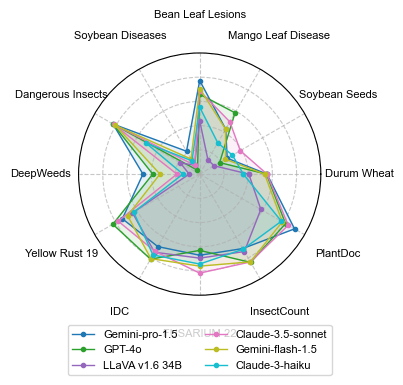

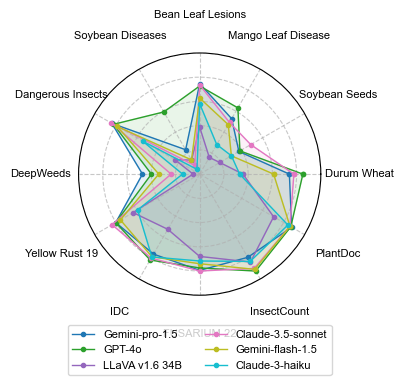

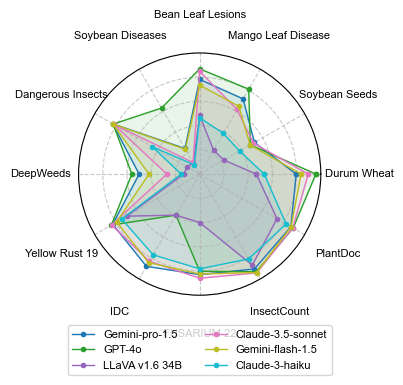

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 8+1,
    'axes.labelsize': 9+1,
    'axes.titlesize': 10+1,
    'xtick.labelsize': 7+1,
    'ytick.labelsize': 7+1,
    'legend.fontsize': 8+1,
})

for shot in [0,2,8]:
    # Assuming result_table is already defined as per your provided data
    result_table=result_table_dict[shot]
    # Prepare the data
    models = result_table.index.tolist()
    datasets = result_table.columns.get_level_values(3).tolist()
    metrics = result_table.columns.get_level_values(1).tolist()
    values = result_table.values

    # Normalize the values based on the metric
    normalized_values = np.zeros_like(values)
    for i, metric in enumerate(metrics):
        # normalized_values[:, i] = values[:, i]
        if metric == 'F1':
            normalized_values[:, i] = values[:, i] 
        elif metric == 'NMAE':
            normalized_values[:, i] = 100-values[:, i]

    # Remove columns with all NaN values
    valid_columns = ~np.all(np.isnan(normalized_values), axis=0)
    normalized_values = normalized_values[:, valid_columns]
    datasets = [d for d, v in zip(datasets, valid_columns) if v]

    # Set up the angles for each dataset
    angles = np.linspace(0, 2*np.pi, len(datasets), endpoint=False)

    # Close the plot by appending the first value to the end
    normalized_values = np.concatenate((normalized_values, normalized_values[:, [0]]), axis=1)
    angles = np.concatenate((angles, [angles[0]]))

    # Set up the plot
    fig, ax = plt.subplots(figsize=(5, 4), subplot_kw=dict(projection='polar'))

    # Color cycle for the models
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
    ax.set_ylim(0, 100)  # Set the range from 0 to 100

    # Plot each model
    for i, model in enumerate(models):
        ax.plot(angles, normalized_values[i], 'o-', linewidth=1, color=colors[i], label=model, markersize=3)
        ax.fill(angles, normalized_values[i], alpha=0.1, color=colors[i])

    # Set the labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(datasets, fontsize=8)
    ax.tick_params(axis='both', which='major', pad=17)

    # Remove radial labels and set grid
    ax.set_yticklabels([])
    ax.grid(True, linestyle='--', alpha=0.7)

    # Adjust the subplot layout
    plt.subplots_adjust(bottom=0.1, top=0.9)

    # Create legend
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize=8, ncol=2)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f'analysis/radar_plots/{shot}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Radar fixed size

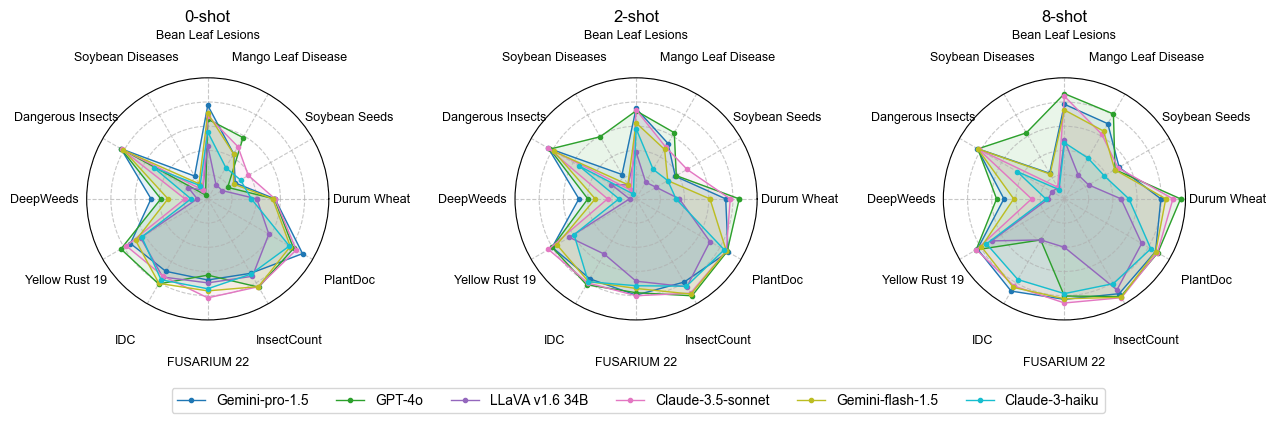

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 10,
})

# Create a single figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(13, 4), subplot_kw=dict(projection='polar'))

for idx, shot in enumerate([0, 2, 8]):
    result_table = result_table_dict[shot]
    
    # Prepare the data
    models = result_table.index.tolist()
    datasets = result_table.columns.get_level_values(3).tolist()
    metrics = result_table.columns.get_level_values(1).tolist()
    values = result_table.values

    # Normalize the values based on the metric
    normalized_values = np.zeros_like(values)
    for i, metric in enumerate(metrics):
        if metric == 'F1':
            normalized_values[:, i] = values[:, i] 
        elif metric == 'NMAE':
            normalized_values[:, i] = 100-values[:, i]

    # Remove columns with all NaN values
    valid_columns = ~np.all(np.isnan(normalized_values), axis=0)
    normalized_values = normalized_values[:, valid_columns]
    datasets = [d for d, v in zip(datasets, valid_columns) if v]

    # Set up the angles for each dataset
    angles = np.linspace(0, 2*np.pi, len(datasets), endpoint=False)

    # Close the plot by appending the first value to the end
    normalized_values = np.concatenate((normalized_values, normalized_values[:, [0]]), axis=1)
    angles = np.concatenate((angles, [angles[0]]))

    ax = axs[idx]
    
    # Color cycle for the models
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
    ax.set_ylim(0, 100)  # Set the range from 0 to 100

    # Plot each model
    for i, model in enumerate(models):
        ax.plot(angles, normalized_values[i], 'o-', linewidth=1, color=colors[i], label=model, markersize=3)
        ax.fill(angles, normalized_values[i], alpha=0.1, color=colors[i])

    # Set the labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(datasets)
    ax.tick_params(axis='both', which='major', pad=20)

    # Remove radial labels and set grid
    ax.set_yticklabels([])
    ax.grid(True, linestyle='--', alpha=0.7)
    
    ax.set_title(f'{shot}-shot')

# Create a single legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(models))

# Adjust layout and save
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Make room for the legend
plt.savefig('analysis/radar_plots/combined.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
result_table_dict[0].head()

Identification (I)                                   \
                           F1 Score                                    
                          Crop Type                     Disease Type   
                        Durum Wheat Soybean Seeds Mango Leaf Disease   
Model                                                                  
GPT-4o                        59.24         23.96              62.74   
LLaVA v1.6 34B                30.45         28.19              15.59   
Gemini-flash-1.5              46.18         26.12              55.71   
Claude-3-haiku                41.27         36.41              17.59   
Claude-3-sonnet               39.25         29.44              18.07   

                                                                   \
                                                                    
                                   Pest Type        Disease Stage   
                 Bean Leaf Lesions DeepWeeds   IP02          SBRD   
Model                                                               
GPT-4o                       80.26     24.21  19.61         44.14   
LLaVA v1.6 34B               51.21      8.73   0.00          5.56   
Gemini-flash-1.5             73.33     39.14  17.81         16.30   
Claude-3-haiku               54.73      6.95    NaN         12.06   
Claude-3-sonnet              48.29      7.77    NaN         22.22   

                 Classification (C)             Quantification (Q)  \
                               NMAE                           NMAE   
                      Disease Stage Leaf Health         Pest Count   
                     Yellow Rust 19 FUSARIUM 22        InsectCount   
Model                                                                
GPT-4o                        20.00       32.50               32.0   
LLaVA v1.6 34B                34.67       24.67                NaN   
Gemini-flash-1.5              34.00       21.67               22.0   
Claude-3-haiku                34.67       20.83                NaN   
Claude-3-sonnet               33.33         NaN                NaN   

                                         
                                         
                 Disease Quantification  
                               PlantDoc  
Model                                    
GPT-4o                            39.92  
LLaVA v1.6 34B                      NaN  
Gemini-flash-1.5                  77.40  
Claude-3-haiku                      NaN  
Claude-3-sonnet                     NaN

# Plots per Dataset

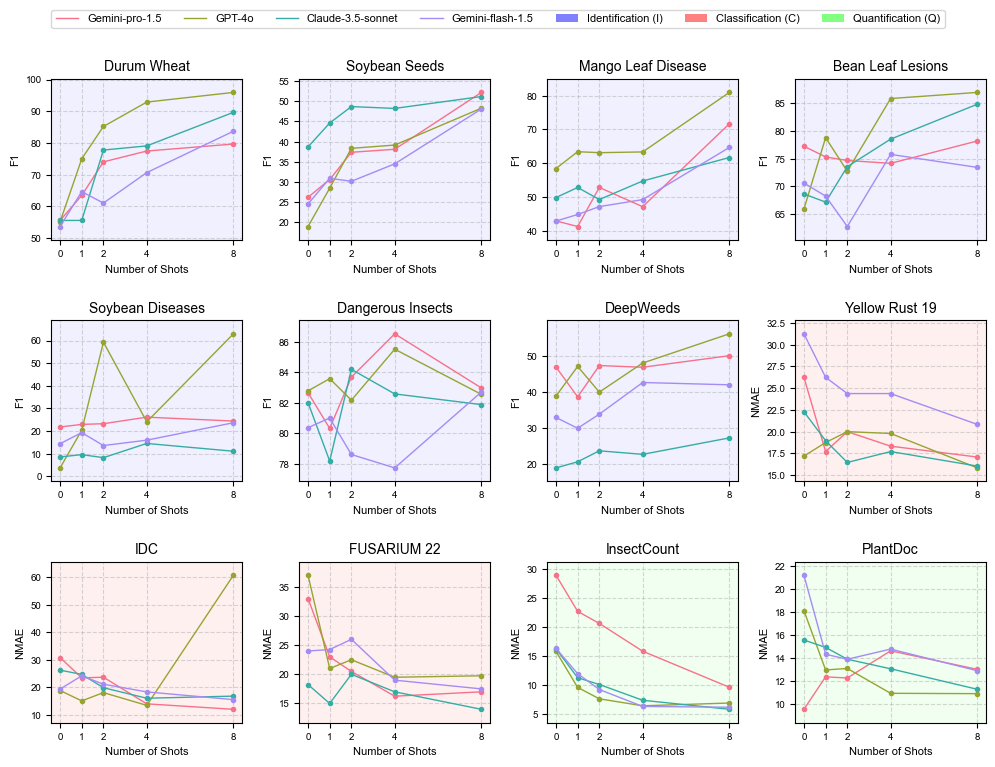

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

# Set up the plot style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 10,
})
# Prepare data
shots = [0, 1, 2, 4, 8]
models = [model for model in result_table_dict[0].index if model not in  ('LLaVA v1.6 34B', 'Claude-3-haiku')]
datasets = [dataset for dataset in result_table_dict[0].columns if dataset[3] != 'IP02']

# Set up the grid
n_datasets = len(datasets)
n_cols = 4
n_rows = math.ceil(n_datasets / n_cols)

# Create the main figure
fig = plt.figure(figsize=(10, 2.5 * n_rows))

# Use GridSpec for more control over subplot positioning
gs = gridspec.GridSpec(n_rows, n_cols)

# Color palette for models
model_colors = sns.color_palette("husl", n_colors=len(models))

# Background colors for problem types (subtle for subplots)
bg_colors = {
    'Identification (I)': '#f0f0ff',
    'Classification (C)': '#fff0f0',
    'Quantification (Q)': '#f0fff0'
}

# Intense colors for problem types (for legend)
legend_colors = {
    'Identification (I)': '#8080ff',
    'Classification (C)': '#ff8080',
    'Quantification (Q)': '#80ff80'
}

# Plot each dataset
for i, dataset in enumerate(datasets):
    row = i // n_cols
    col = i % n_cols
    
    # Center the plots in the last row
    if row == n_rows - 1:
        n_plots_last_row = n_datasets - (n_rows - 1) * n_cols
        offset = (n_cols - n_plots_last_row) // 2
        ax = fig.add_subplot(gs[row, col + offset])
    else:
        ax = fig.add_subplot(gs[row, col])
    
    ax.set_facecolor(bg_colors[dataset[0]])
    
    all_values = []
    for j, model in enumerate(models):
        values = [result_table_dict[shot].loc[model, dataset] for shot in shots]
        all_values.extend(values)
        ax.plot(shots, values, marker='o', markersize=3, linewidth=1, color=model_colors[j])
    
    ax.set_title(f'{dataset[3]}', fontsize=10)
    ax.set_xlabel('Number of Shots', fontsize=8)
    ax.set_ylabel(dataset[1], fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=7)
    
    # Set y-axis limits dynamically
    y_min, y_max = min(all_values), max(all_values)
    y_range = y_max - y_min
    ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Set x-axis ticks
    ax.set_xticks(shots)

# Create a custom legend
legend_elements = [plt.Line2D([0], [0], color=model_colors[i], lw=1, label=model) 
                   for i, model in enumerate(models)]

# Add problem type legend with intense colors
problem_type_patches = [mpatches.Patch(facecolor=color, edgecolor='none', label=ptype) 
                        for ptype, color in legend_colors.items()]
legend_elements.extend(problem_type_patches)

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.02), 
           ncol=len(models) + len(bg_colors), fontsize=8)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.5, wspace=0.3)  # Make room for the legend and adjust spacing

# Save the figure
plt.savefig('analysis/individual_plots.pdf', bbox_inches='tight')
# Show the plot
plt.show()

# Plots per Classes

In [108]:


# Dataset mapping is given earlier. 
# We will use it to get the categories, metrics, and subcategories for each dataset

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 10,
})
# Define the datasets and their categories, metrics, and subcategories


def calculate_f1_scores(true_labels, pred_labels):
    classes = np.unique(true_labels)
    f1_scores = {}
    for cls in classes:
        true_binary = (true_labels == cls)
        pred_binary = (pred_labels == cls)
        f1 = f1_score(true_binary, pred_binary, zero_division=0)
        f1_scores[cls] = f1
    return f1_scores

# Get the list of model folders
model_folders = [f for f in os.listdir('results') if os.path.isdir(os.path.join('results', f))]

# Initialize results dictionary
results = {model: {} for model in model_folders}

# Process each dataset for each model
for model in model_folders:
    for dataset, (category, metric, subcategory) in dataset_mapping.items():
        if category == 'Quantification (Q)':
            continue  # Skip quantification for now
        try:
            df = pd.read_csv(f'results/{model}/{dataset}.csv', engine='python')
            true_labels = df['1'].fillna('Unknown').astype(str)
            zero_shot = df['# of Shots 0'].fillna('NA_placeholder').astype(str)
            eight_shot = df['# of Shots 8'].fillna('NA_placeholder').astype(str)
            
            f1_zero = calculate_f1_scores(true_labels, zero_shot)
            f1_eight = calculate_f1_scores(true_labels, eight_shot)
            
            # Sort categories by 0-shot F1 score
            sorted_zero = sorted(f1_zero.items(), key=lambda x: x[1], reverse=True)
            
            # Get highest, median, and lowest performing categories based on 0-shot
            n = len(sorted_zero)
            highest = sorted_zero[0][0]
            median = sorted_zero[n//2][0]
            lowest = sorted_zero[-1][0]
            
            results[model][dataset] = {
                '0-shot': {
                    'Highest': {'category': highest, 'score': f1_zero[highest]},
                    'Median': {'category': median, 'score': f1_zero[median]},
                    'Lowest': {'category': lowest, 'score': f1_zero[lowest]}
                },
                '8-shot': {
                    'Highest': {'category': highest, 'score': f1_eight[highest]},
                    'Median': {'category': median, 'score': f1_eight[median]},
                    'Lowest': {'category': lowest, 'score': f1_eight[lowest]}
                }
            }
        except Exception as e:
            print(f"Error processing {model}/{dataset}: {str(e)}")
            results[model][dataset] = {
                '0-shot': {
                    'Highest': {'category': 'N/A', 'score': np.nan},
                    'Median': {'category': 'N/A', 'score': np.nan},
                    'Lowest': {'category': 'N/A', 'score': np.nan}
                },
                '8-shot': {
                    'Highest': {'category': 'N/A', 'score': np.nan},
                    'Median': {'category': 'N/A', 'score': np.nan},
                    'Lowest': {'category': 'N/A', 'score': np.nan}
                }
            }

def create_plot(dataset, results):
    fig, ax = plt.subplots(figsize=(6, 3))  # Decreased figure size to half
    bar_width = 0.15
    opacity = 0.8
    padding = 0.02  # 2% padding for empty or zero values

    performances = ['Highest', 'Median', 'Lowest']
    num_models = len(model_folders)
    
    for p_idx, performance in enumerate(performances):
        for m_idx, model in enumerate(model_folders):
            zero_shot = results[model][dataset]['0-shot'][performance]['score']
            eight_shot = results[model][dataset]['8-shot'][performance]['score']
            category = results[model][dataset]['0-shot'][performance]['category']
            
            x = p_idx * (num_models + 1) * bar_width + m_idx * bar_width
            
            # Add padding for empty or zero values
            zero_shot = max(zero_shot, padding) if not np.isnan(zero_shot) else padding
            eight_shot = max(eight_shot, padding) if not np.isnan(eight_shot) else padding
            
            ax.bar(x, zero_shot, bar_width, alpha=opacity, color=plt.cm.Set3(m_idx), 
                   label=model if p_idx == 0 else "", hatch='')
            ax.bar(x, eight_shot, bar_width, alpha=opacity, color=plt.cm.Set3(m_idx), 
                   hatch='/////', bottom=zero_shot)
        
        # Add category name
        x_center = p_idx * (num_models + 1) * bar_width + (num_models - 1) * bar_width / 2
        ax.text(x_center, -0.05, f"{performance}\n({category})", ha='center', va='top', transform=ax.get_xaxis_transform())

    ax.set_ylabel('F1 Score')
    ax.set_title(f'F1 Scores for {dataset}')
    ax.set_ylim(0, 1)  # Assuming F1 scores are between 0 and 1
    
    # Remove x-axis ticks
    ax.set_xticks([])
    
    # Add a legend for models
    legend = ax.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add clarification for 0-shot and 8-shot under the legend
    ax.text(1.05, 0, 'Solid: 0-shot F1 Score \n /////  : 8-shot Additional Gain in F1', transform=ax.transAxes, 
            verticalalignment='bottom', horizontalalignment='left')

    plt.tight_layout()
    plt.savefig(f'analysis/individual_bar_plots/{dataset}_f1_scores.pdf', dpi=300, bbox_inches='tight')
    plt.close()

# Generate plots
for dataset, (category, metric, subcategory) in dataset_mapping.items():
    if category == 'Quantification (Q)':
        continue
    create_plot(dataset, results)

print("Plots have been generated and saved.")


KeyboardInterrupt: 

# Impact of Exact Few shot examples

In [53]:
import pandas as pd
import numpy as np
import os
import ast
from sklearn.metrics import precision_recall_fscore_support

def calculate_f1_score(true_labels, pred_labels):
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)
    return f1 * 100  # Convert to percentage

def calculate_baseline(model_folder, dataset):
    file_path = f'results/{model_folder}/{dataset}.csv'
    df = pd.read_csv(file_path, engine='python')
    
    true_labels = df['1'].fillna('Unknown')
    pred_labels_0 = df['# of Shots 0'].fillna('NA_placeholder')
    
    return calculate_f1_score(true_labels, pred_labels_0)

def analyze_example_impact(model_folder, dataset, shot):
    file_path = f'results/{model_folder}/{dataset}.csv'
    df = pd.read_csv(file_path, engine='python')
    
    true_labels = df['1'].fillna('Unknown')
    pred_labels = df[f'# of Shots {shot}'].fillna('NA_placeholder')
    
    example_cats = f'Example Categories {shot}'
    df['has_exact'] = df.apply(lambda row: 
        row['1'] in ast.literal_eval(row[example_cats]) if isinstance(row[example_cats], str) else False, 
        axis=1
    )
    
    perf_with_exact = calculate_f1_score(true_labels[df['has_exact']], pred_labels[df['has_exact']])
    perf_without_exact = calculate_f1_score(true_labels[~df['has_exact']], pred_labels[~df['has_exact']])
    
    return perf_with_exact, perf_without_exact

# Assuming dataset_mapping is defined elsewhere in your code
# dataset_mapping = {...}

results = {}
baselines = {}
for dataset, (category, metric, subcategory) in dataset_mapping.items():
    if category == 'Identification (I)':
        results[dataset] = {shot: {'with_exact': [], 'without_exact': []} for shot in [1, 2, 4, 8]}
        baselines[dataset] = []
        for model_folder in os.listdir('results'):
            if os.path.isdir(os.path.join('results', model_folder)) and model_folder != 'LLaVA v1.6 34B':
                try:
                    # Calculate baseline (0-shot) for each model
                    baseline = calculate_baseline(model_folder, dataset)
                    baselines[dataset].append(baseline)
                    
                    for shot in [1, 2, 4, 8]:
                        with_exact, without_exact = analyze_example_impact(model_folder, dataset, shot)
                        results[dataset][shot]['with_exact'].append(with_exact)
                        results[dataset][shot]['without_exact'].append(without_exact)
                except Exception as e:
                    print(f"Error processing {model_folder}/{dataset}: {str(e)}")

# Create DataFrame
data = []
for dataset in results:
    row = {'Dataset': dataset}
    avg_0shot = np.nanmean(baselines[dataset])
    row[('Baseline', '0-shot')] = f"{avg_0shot:05.2f}"
    
    total_with_exact = 0
    total_without_exact = 0
    for shot in [1, 2, 4, 8]:
        avg_with_exact = np.nanmean(results[dataset][shot]['with_exact'])
        avg_without_exact = np.nanmean(results[dataset][shot]['without_exact'])
        
        delta_with = avg_with_exact - avg_0shot
        delta_without = avg_without_exact - avg_0shot
        
        row[('Bullseye', f'{shot}-shot')] = f"{delta_with:+06.2f}"
        row[('Non-Bullseye', f'{shot}-shot')] = f"{delta_without:+06.2f}"
        
        total_with_exact += delta_with
        total_without_exact += delta_without
    
    row[('Bullseye', 'Average Impact')] = f"{total_with_exact / 4:+06.2f}"
    row[('Non-Bullseye', 'Average Impact')] = f"{total_without_exact / 4:+06.2f}"
    
    data.append(row)

df_results = pd.DataFrame(data)
df_results.set_index('Dataset', inplace=True)

# Reorder columns
column_order = [('Baseline', '0-shot')] + \
               [('Bullseye', f'{shot}-shot') for shot in [1, 2, 4, 8]] + \
               [('Bullseye', 'Average Impact')] + \
               [('Non-Bullseye', f'{shot}-shot') for shot in [1, 2, 4, 8]] + \
               [('Non-Bullseye', 'Average Impact')]
df_results = df_results.reindex(columns=pd.MultiIndex.from_tuples(column_order))

# Calculate average across datasets
avg_row = df_results.apply(lambda x: pd.to_numeric(x.str.lstrip('+'), errors='coerce').mean())
avg_row = avg_row.apply(lambda x: f"{x:+06.2f}" if pd.notnull(x) else x)
avg_row[('Baseline', '0-shot')] = f"{float(avg_row[('Baseline', '0-shot')].lstrip('+')):05.2f}"

# Create a DataFrame for the average row and concatenate it with df_results
avg_df = pd.DataFrame([avg_row], index=['Average'])
bulleye_results = pd.concat([df_results, avg_df])

print(bulleye_results)

                   Baseline Bullseye                                         \
                     0-shot   1-shot  2-shot  4-shot  8-shot Average Impact   
Durum Wheat           51.18   +31.10  +23.74  +28.02  +30.67         +28.38   
Soybean Seeds         27.95   +27.10  +15.54  +13.79  +21.77         +19.55   
Mango Leaf Disease    44.76   +22.61  +22.90  +17.34  +28.30         +22.79   
Bean Leaf Lesions     67.53   +11.46  +05.01  +07.67  +06.90         +07.76   
Soybean Diseases      12.23   +49.05  +17.71  +09.26  +06.54         +20.64   
Dangerous Insects     75.83   -12.05  -10.92  -12.67  -04.15         -09.95   
DeepWeeds             30.23   +22.37  +24.79  +13.85  +12.86         +18.47   
Average               44.24   +21.66  +14.11  +11.04  +14.70         +15.38   

                   Non-Bullseye                                         
                         1-shot  2-shot  4-shot  8-shot Average Impact  
Durum Wheat              -01.74  +01.03  -04.39  -11.85        

In [56]:
bulleye_results.head(10)

Baseline Bullseye                                         \
                     0-shot   1-shot  2-shot  4-shot  8-shot Average Impact   
Durum Wheat           51.18   +31.10  +23.74  +28.02  +30.67         +28.38   
Soybean Seeds         27.95   +27.10  +15.54  +13.79  +21.77         +19.55   
Mango Leaf Disease    44.76   +22.61  +22.90  +17.34  +28.30         +22.79   
Bean Leaf Lesions     67.53   +11.46  +05.01  +07.67  +06.90         +07.76   
Soybean Diseases      12.23   +49.05  +17.71  +09.26  +06.54         +20.64   
Dangerous Insects     75.83   -12.05  -10.92  -12.67  -04.15         -09.95   
DeepWeeds             30.23   +22.37  +24.79  +13.85  +12.86         +18.47   
Average               44.24   +21.66  +14.11  +11.04  +14.70         +15.38   

                   Non-Bullseye                                         
                         1-shot  2-shot  4-shot  8-shot Average Impact  
Durum Wheat              -01.74  +01.03  -04.39  -11.85         -04.24  
Soybean Seeds            -01.48  +05.57  +05.44  +09.20         +04.68  
Mango Leaf Disease       -02.02  -02.96  -00.40  +03.31         -00.52  
Bean Leaf Lesions        -06.08  -05.61  -09.65  -07.87         -07.30  
Soybean Diseases         +00.26  +06.98  +04.95  +11.73         +05.98  
Dangerous Insects        -00.92  +02.04  +03.37  +01.90         +01.60  
DeepWeeds                -02.03  -03.32  -00.35  +01.55         -01.04  
Average                  -02.00  +00.53  -00.15  +01.14         -00.12

# with highlights

In [55]:
import pandas as pd
import numpy as np

def highlight_and_format(s):
    # Convert to numeric, ignoring the '+' sign and '%'
    numeric_s = pd.to_numeric(s.str.replace('+', '').str.replace('%', ''), errors='coerce')
    
    # Identify shot columns (1, 2, 4, 8) for both Bullseye and Non-Bullseye
    shot_columns = [col for col in s.index if col[1] in ['1-shot', '2-shot', '4-shot', '8-shot']]
    
    # Find highest and lowest values in shot columns
    shot_values = numeric_s[shot_columns]
    highest = shot_values.max()
    lowest = shot_values.min()
    
    formatted = []
    for idx, value in s.items():
        if 'Average Impact' in idx[1]:
            formatted.append(f'\\textbf{{{value}}}')
        elif idx in shot_columns:
            if numeric_s[idx] == highest:
                formatted.append(f'\\cellcolor{{green!25}}{value}')
            elif numeric_s[idx] == lowest:
                formatted.append(f'\\cellcolor{{red!25}}{value}')
            else:
                formatted.append(value)
        else:
            formatted.append(value)
    
    return formatted

def to_latex_with_multicolumn(df):
    # Create a copy of the DataFrame to avoid modifying the original
    df_highlighted = df.copy()

    # Apply highlighting and formatting to each row
    for idx in df_highlighted.index:
        row = df_highlighted.loc[idx]
        formatted_row = highlight_and_format(row)
        df_highlighted.loc[idx] = formatted_row

    latex = df_highlighted.to_latex(multicolumn=True, multicolumn_format='c', multirow=True,
                        column_format='l' + 'c'*len(df_highlighted.columns), 
                        escape=False)
    
    # Remove the \toprule, \midrule, and \bottomrule commands
    latex = latex.replace('\\toprule', '\\hline')
    latex = latex.replace('\\midrule', '\\hline')
    latex = latex.replace('\\bottomrule', '\\hline')
    
    return latex

# Convert to LaTeX
latex_table = to_latex_with_multicolumn(bulleye_results)

# Add caption, label, and font details
latex_table = """\\begin{table*}[htbp]
\\centering
\\caption{Few Shot Learning: Impact of having at least 1 example with same category as ground truth (Bullseye Example). 
\\protect\\colorbox{green!25}{\\strut Highest} 
\\protect\\colorbox{red!25}{\\strut Lowest} across 1, 2, 4, and 8-shot settings for both Bullseye and Non-Bullseye. 
Average Impact values are in \\textbf{bold}.}
\\label{tab:Bullseye}

{\\fontsize{7pt}{8pt}\\selectfont
""" + latex_table + """}

\\end{table*}"""

print(latex_table)

\begin{table*}[htbp]
\centering
\caption{Few Shot Learning: Impact of having at least 1 example with same category as ground truth (Bullseye Example). 
\protect\colorbox{green!25}{\strut Highest} 
\protect\colorbox{red!25}{\strut Lowest} across 1, 2, 4, and 8-shot settings for both Bullseye and Non-Bullseye. 
Average Impact values are in \textbf{bold}.}
\label{tab:Bullseye}

{\fontsize{7pt}{8pt}\selectfont
\begin{tabular}{lccccccccccc}
\hline
 & Baseline & \multicolumn{5}{c}{Bullseye} & \multicolumn{5}{c}{Non-Bullseye} \\
 & 0-shot & 1-shot & 2-shot & 4-shot & 8-shot & Average Impact & 1-shot & 2-shot & 4-shot & 8-shot & Average Impact \\
\hline
Durum Wheat & 51.18 & \cellcolor{green!25}+31.10 & +23.74 & +28.02 & +30.67 & \textbf{+28.38} & -01.74 & +01.03 & -04.39 & \cellcolor{red!25}-11.85 & \textbf{-04.24} \\
Soybean Seeds & 27.95 & \cellcolor{green!25}+27.10 & +15.54 & +13.79 & +21.77 & \textbf{+19.55} & \cellcolor{red!25}-01.48 & +05.57 & +05.44 & +09.20 & \textbf{+04.68} \\
Mango 

# fixing


## Debugging issue with insect (just use logs for explaination)



In [51]:
# import pandas as pd
# import numpy as np
# import os
# import ast
# from sklearn.metrics import precision_recall_fscore_support

# def calculate_f1_score(true_labels, pred_labels):
#     precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)
#     return f1 * 100  # Convert to percentage

# def analyze_performance(model_folder, dataset, shot):
#     file_path = f'results/{model_folder}/{dataset}.csv'
#     df = pd.read_csv(file_path, engine='python')
    
#     true_labels = df['1'].fillna('Unknown')
#     pred_labels_0 = df['# of Shots 0'].fillna('NA_placeholder')
#     pred_labels = df[f'# of Shots {shot}'].fillna('NA_placeholder')
    
#     baseline = calculate_f1_score(true_labels, pred_labels_0)
#     performance = calculate_f1_score(true_labels, pred_labels)
    
#     example_cats = f'Example Categories {shot}'
#     df['has_exact'] = df.apply(lambda row: 
#         row['1'] in ast.literal_eval(row[example_cats]) if isinstance(row[example_cats], str) else False, 
#         axis=1
#     )
    
#     perf_with_exact = calculate_f1_score(true_labels[df['has_exact']], pred_labels[df['has_exact']])
#     perf_without_exact = calculate_f1_score(true_labels[~df['has_exact']], pred_labels[~df['has_exact']])
#     bullseye_proportion = df['has_exact'].mean()
    
#     return baseline, performance, perf_with_exact, perf_without_exact, bullseye_proportion

# # Assuming dataset_mapping is defined
# dataset_mapping = {
#     'Durum Wheat': ('Identification (I)', 'F1', 'Seed Morphology'),
#     'Soybean Seeds': ('Identification (I)', 'F1', 'Seed Morphology'),
#     'Mango Leaf Disease': ('Identification (I)', 'F1', 'Foliar Stress'),
#     'Bean Leaf Lesions': ('Identification (I)', 'F1', 'Foliar Stress'),
#     'Soybean Diseases': ('Identification (I)', 'F1', 'Foliar Stress'),
#     'Dangerous Insects': ('Identification (I)', 'F1', 'Invasive Species'),
#     'DeepWeeds': ('Identification (I)', 'F1', 'Invasive Species'),
# }

# results = {}
# for dataset in dataset_mapping:
#     results[dataset] = {shot: {'baseline': [], 'performance': [], 'with_exact': [], 'without_exact': [], 'bullseye_prop': []} for shot in [0, 1, 2, 4, 8]}

# for dataset in dataset_mapping:
#     print(f"\nAnalyzing {dataset}:")
#     for model_folder in os.listdir('results'):
#         if os.path.isdir(os.path.join('results', model_folder)) and model_folder != 'LLaVA v1.6 34B':
#             print(f"  Model: {model_folder}")
#             try:
#                 for shot in [0, 1, 2, 4, 8]:
#                     baseline, performance, with_exact, without_exact, bullseye_prop = analyze_performance(model_folder, dataset, shot)
#                     results[dataset][shot]['baseline'].append(baseline)
#                     results[dataset][shot]['performance'].append(performance)
#                     results[dataset][shot]['with_exact'].append(with_exact)
#                     results[dataset][shot]['without_exact'].append(without_exact)
#                     results[dataset][shot]['bullseye_prop'].append(bullseye_prop)
                    
#                     print(f"    {shot}-shot: Baseline={baseline:.2f}, Performance={performance:.2f}, Delta={performance-baseline:.2f}")
#                     if shot > 0:
#                         print(f"      With exact={with_exact:.2f}, Without exact={without_exact:.2f}, Bullseye prop={bullseye_prop:.2%}")
#             except Exception as e:
#                 print(f"    Error processing {model_folder}/{dataset}: {str(e)}")

# print("\nAggregated Results:")
# for dataset in results:
#     print(f"\n{dataset}:")
#     avg_baseline = np.mean(results[dataset][0]['baseline'])
#     print(f"  Average Baseline (0-shot): {avg_baseline:.2f}")
#     for shot in [1, 2, 4, 8]:
#         avg_performance = np.mean(results[dataset][shot]['performance'])
#         avg_with_exact = np.mean(results[dataset][shot]['with_exact'])
#         avg_without_exact = np.mean(results[dataset][shot]['without_exact'])
#         avg_bullseye_prop = np.mean(results[dataset][shot]['bullseye_prop'])
#         print(f"  {shot}-shot:")
#         print(f"    Avg Performance: {avg_performance:.2f}, Delta: {avg_performance - avg_baseline:.2f}")
#         print(f"    Avg With Exact: {avg_with_exact:.2f}, Delta: {avg_with_exact - avg_baseline:.2f}")
#         print(f"    Avg Without Exact: {avg_without_exact:.2f}, Delta: {avg_without_exact - avg_baseline:.2f}")
#         print(f"    Avg Bullseye Proportion: {avg_bullseye_prop:.2%}")


Analyzing Durum Wheat:
  Model: Gemini-pro-1.5
    0-shot: Baseline=55.56, Performance=55.56, Delta=0.00
    1-shot: Baseline=55.56, Performance=63.44, Delta=7.89
      With exact=85.32, Without exact=53.91, Bullseye prop=31.31%
    2-shot: Baseline=55.56, Performance=74.03, Delta=18.47
      With exact=85.96, Without exact=54.82, Bullseye prop=57.58%
    4-shot: Baseline=55.56, Performance=77.45, Delta=21.89
      With exact=86.42, Without exact=33.94, Bullseye prop=82.83%
    8-shot: Baseline=55.56, Performance=79.66, Delta=24.10
      With exact=83.02, Without exact=0.00, Bullseye prop=95.96%
  Model: GPT-4o
    0-shot: Baseline=55.10, Performance=55.10, Delta=0.00
    1-shot: Baseline=55.10, Performance=75.00, Delta=19.90
      With exact=83.04, Without exact=71.80, Bullseye prop=24.24%
    2-shot: Baseline=55.10, Performance=85.19, Delta=30.09
      With exact=92.44, Without exact=76.56, Bullseye prop=55.56%
    4-shot: Baseline=55.10, Performance=92.89, Delta=37.79
      With ex